## We can derive expected, upper & lower bound.
Assuming normal distribution:

    upper bound = exp_r + 1.96*std/np.sqrt(T)    
    lower bound = exp_r - 1.96*std/np.sqrt(T)
    

In [3]:
%store -r model_ewma_5years
%store -r starting_dates1

In [1]:
import pandas as pd 
import numpy as np
import pandas_datareader as pdr 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.options.display.float_format = '{:,.2f}'.format

C:\Users\Momir\.conda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
sigma = model_ewma_5years['Hybrid']
sigma_daily = sigma/np.sqrt(252)

# Realized Return - Monthly

In [5]:
gspc = pd.read_csv('Data//^GSPC.csv')
gspc = gspc.set_index('Date')
gspc.index = pd.to_datetime(gspc.index)
gspc = gspc.loc[starting_dates1]
gspc = np.log (gspc) - np.log(gspc.shift(1))
realized_R = gspc.shift(-1)

In [9]:
def random_walk (MC_trials):
    
    """""
    MC_trials - number of trials, e.g. 1000
    the function returns MONTHLY return estimate
    mean return assumed to be zero
    """""

    T = 21
    t = 1
    N = T/t
    p0 = 100

    returns = pd.DataFrame(index=model_ewma_5years.index, columns=np.arange(MC_trials))


    total = 0
    while total < MC_trials:
        for z in range (len(sigma_daily)):
            price = [100]   
            for i in range (int (N)-1):
                price.append(price[i] * np.exp (np.sqrt(MC_trials) * sigma_daily[z]*np.sqrt(t)*np.random.randn()))
            returns.iloc[[z], [total]] =  np.log(price[-1]) - np.log (price[0])
        total+=1
        
    return returns  

In [10]:
returns = random_walk (1000)

In [7]:
def random_walk1 (MC_trials, daily_return):
    
    """""
    MC_trials - number of trials, e.g. 1000
    the function returns MONTHLY return estimate 
    
    daily return - estimating mean return for the month
    """""

    T = 21
    t = 1
    N = T/t
    p0 = 100

    returns = pd.DataFrame(index=model_ewma_5years.index, columns=np.arange(MC_trials))


    total = 0
    while total < MC_trials:
        for z in range (len(sigma_daily)):
            price = [100]   
            for i in range (int (N)-1):
                price.append(price[i] * np.exp (daily_return[z] + np.sqrt(MC_trials) * sigma_daily[z]*np.sqrt(t)*np.random.randn()))
            returns.iloc[[z], [total]] =  np.log(price[-1]) - np.log (price[0])
        total+=1
        
    return returns  

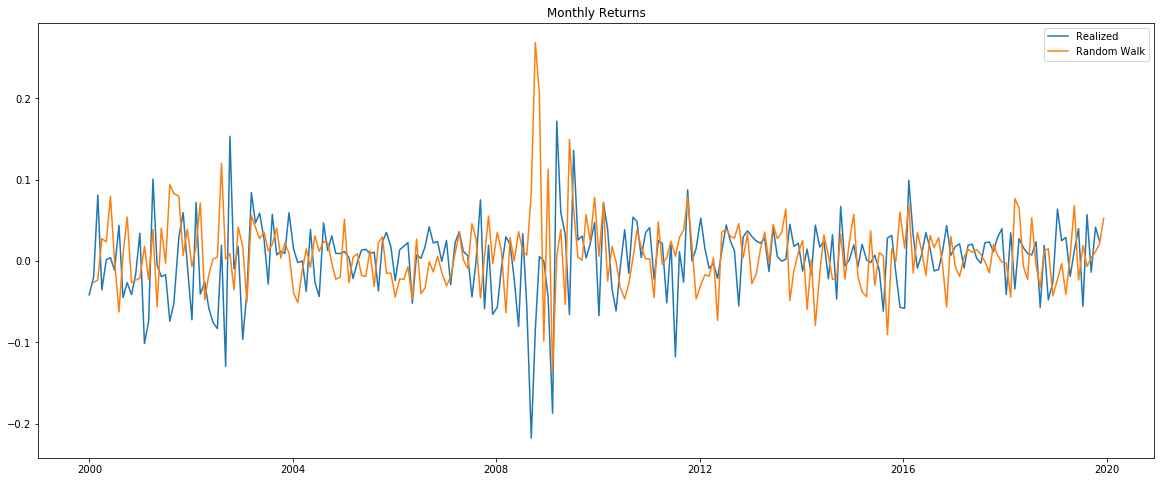

In [11]:
fig, ax = plt.subplots (figsize = (20, 8))
ax.plot (realized_R, label = 'Realized')
ax.plot (np.mean(returns, axis = 1), label = 'Random Walk')
ax.legend()
plt.title('Monthly Returns')
plt.show()

In [177]:
%store returns 

Stored 'returns' (DataFrame)


In [12]:
df = pd.DataFrame(data = np.asarray (realized_R['Adj Close'][1:]), index = realized_R.index[1:], columns = ['Realized'])
df['Expected'] = np.mean(returns, axis = 1)

In [14]:
print ('Realized Return(t) = alpha + b1 * Expected_Return(t+1)')
print ('-----------------------------------------------------------------------------------------')
regress = smf.ols(formula = 'Realized  ~ Expected', 
              data=df[1:-1])
model = regress.fit()

model.summary()

Realized Return(t) = alpha + b1 * Expected_Return(t+1)
-----------------------------------------------------------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Realized   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5108
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.475
Time:                        02:49:53   Log-Likelihood:                 391.66
No. Observations:                 237   AIC:                            -779.3
Df Residuals:                     235   BIC:                            -772.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0039      0.003      1.272      0.205      -0.002       0.010
Expected      -0.0496      0.069     -0.715      0.475      -0.187       0.087
==============================================================================
Omnibus:                       40.416   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.965
Skew:                          -0.625   Prob(JB):                     2.73e-33
Kurtosis:                       6.691   Cond. No.                         23.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

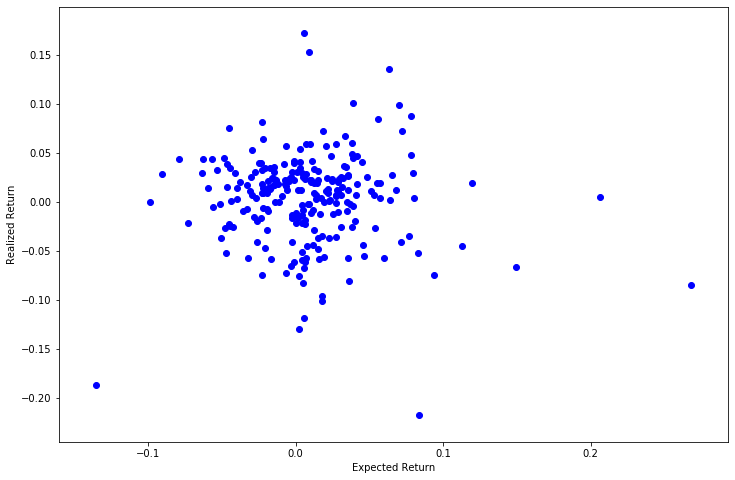

In [16]:
plt.figure(figsize=(12,8));
plt.scatter(df['Expected'], df['Realized'], 
           c='blue', marker='o')
plt.xlabel('Expected Return')
plt.ylabel("Realized Return")

plt.show()

# Trying to determine bear market ex-ante

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

cum_ret = []
for i in range(len(gspc)-252):
    cum_ret.append (float (np.mean(gspc[i:i+252])))
cum_ret = pd.Series(cum_ret, index = gspc.index[252:])


thrshld = pd.qcut (model_ewma_5years['Hybrid'], 5, retbins=True)[1][4]
thrshld1 = pd.qcut (model_ewma_5years.pct_change()['Hybrid'], 5, retbins=True)[1][4] # didn't help
thrshld2 = pd.qcut (cum_ret.pct_change()*-1, 5, retbins = True)[1][4] * -1 # didn't help

market_environment = []
for i in range(len(model_ewma_5years)):
    if np.sign (cum_ret[model_ewma_5years.index][i]) == -1 or model_ewma_5years['Hybrid'][i]>=thrshld:
        market_environment.append('bear')
    else:
        market_environment.append('non_bear')
        
market_environment = pd.Series(market_environment[:-1], index = Sharpes.index)
market_env = pd.get_dummies(market_environment)

bears_alt = (market_env['bear'])


market_environment = pd.DataFrame (data = None, index = Sharpe_diff.index, columns=["Market_env"])
market_environment[:] = 'non_bear'
for i in range(len(bear_markets)):
    market_environment[(market_environment.index>=bear_markets[i][0])*(market_environment.index<=bear_markets[i][-1])] = 'bear'

market_env = pd.get_dummies(market_environment)
market_env.columns = ['bear', 'non_bear']

X = market_env['bear'].copy()
X = sm.add_constant(X)
y = Sharpe_diff.copy()

model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())


compare_bear = (pd.concat ([(market_env['bear'][model_ewma_5years.index]), bears_alt], axis = 1))
compare_bear.columns = ['Real', 'Estimated']
np.sum (compare_bear['Real'] == compare_bear['Estimated']) / len (compare_bear)


mix_eq = 0.75 * port_daily['1/N'] + 0.25 * port_daily['EWMA_VIX_adj']
for i in range(len(compare_bear)):
    if compare_bear['Estimated'][i] == 1:
        mix_eq[(mix_eq.index>=compare_bear.index[i]) * (mix_eq.index<=compare_bear.index[i+1])] = 0.75 * port_daily['EWMA_VIX_adj'][(port_daily.index>=compare_bear.index[i]) * (port_daily.index<=compare_bear.index[i+1])] + 0.25 * port_daily['1/N'][(port_daily.index>=compare_bear.index[i]) * (port_daily.index<=compare_bear.index[i+1])]
        
port_daily['NEW'] = mix_eq

np.sum (compare_bear['Real'] == compare_bear['Estimated']) / len(compare_bear), compare_bear.loc[bear_markets[5]]